**Load Libraries**

In [25]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
import cv2

In [31]:
SEED = 77
IMG_SIZE = 512

In [9]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [10]:
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

In [15]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)

## Visualize Inputs

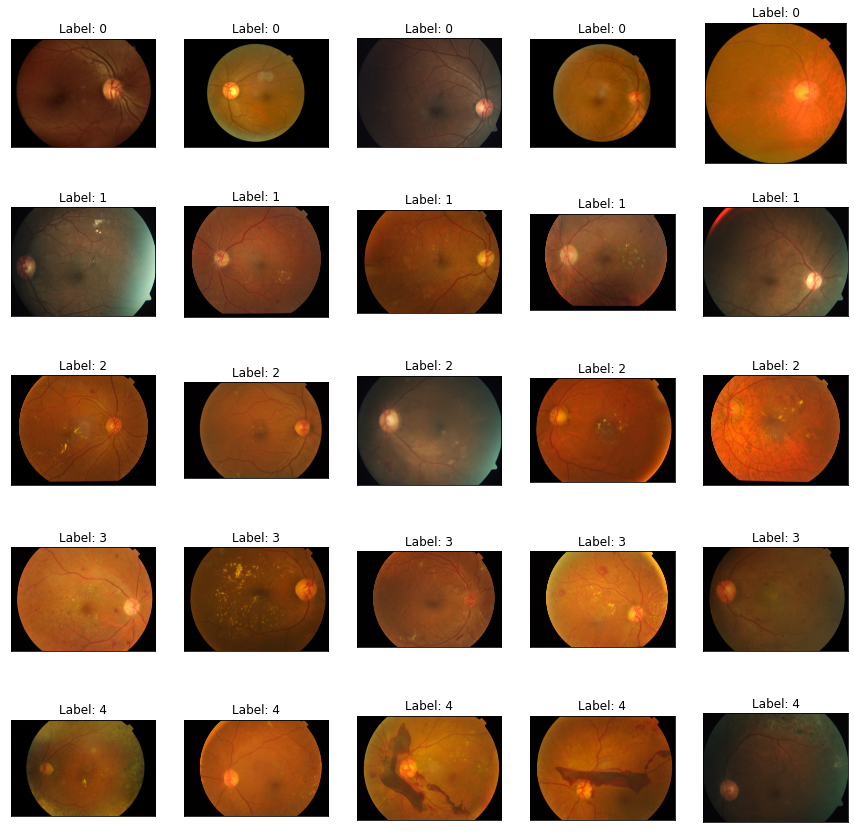

In [30]:

fig = plt.figure(figsize=(15,15))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
        ax.set_title('Label: %d' % (class_id) )


## Pre Processing

In [32]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

In [35]:
def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [42]:
def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

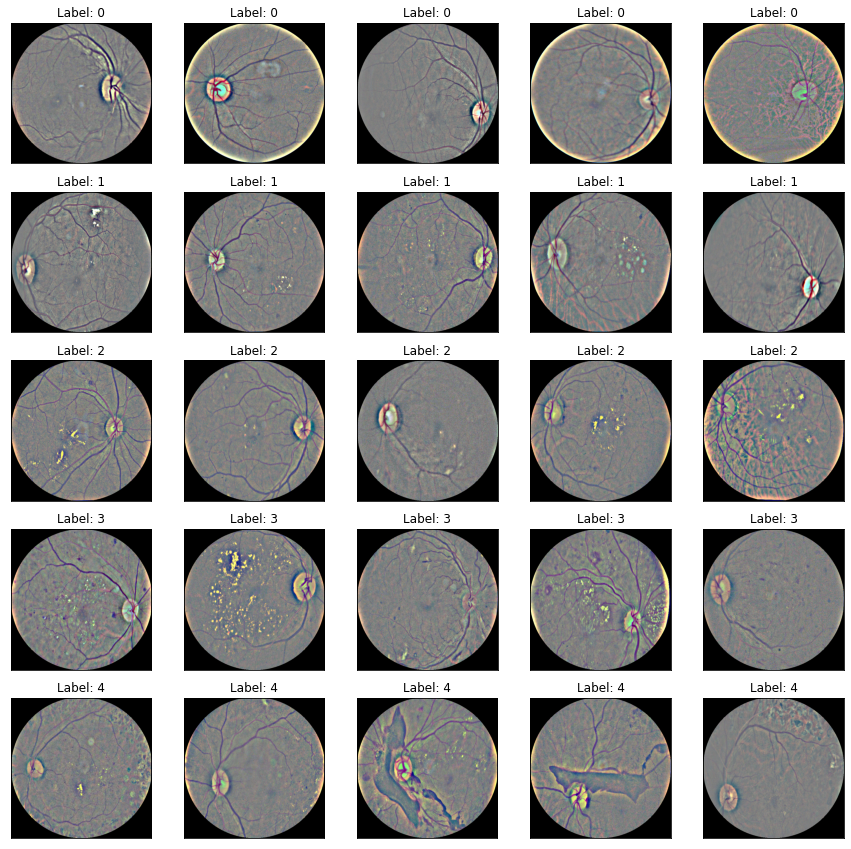

In [43]:

fig = plt.figure(figsize=(15,15))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])

        image = load_ben_color(path, sigmaX=10)
        im = circle_crop(image)
        
        plt.imshow(im)
        
        ax.set_title('Label: %d' % (class_id) )
